# What to use?
Raj Prasad
July 2019

[html version](https://daddyprasad5.github.io/what_to_use.html) - with all the code hidden away for a quick read

[jupyter notebook version](https://github.com/daddyprasad5/thinkful/blob/master/what_to_use.ipynb) - with all the code exposed in an interactive notebook

Using selected questions from the 2012 and 2014 editions of the [European Social Survey](http://www.europeansocialsurvey.org/data/round-index.html), address the following questions. Keep track of your code and results in a Jupyter notebook or other source that you can share with your mentor. For each question, explain why you chose the approach you did.

Here is the [data file](https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/ESS_practice_data/ESSdata_Thinkful.csv). And here is the [codebook](https://thinkful-ed.github.io/data-201-resources/ESS_practice_data/ESS_codebook.html), with information about the variable coding and content.

In this dataset, the same participants answered questions in 2012 and again 2014.

1. Did people become less trusting from 2012 to 2014? Compute results for each country in the sample.
2. Did people become happier from 2012 to 2014? Compute results for each country in the sample.
3. Who reported watching more TV in 2012, men or women?
4. Who was more likely to believe people were fair in 2012, people living with a partner or people living alone?
5. Pick three or four of the countries in the sample and compare how often people met socially in 2014. Are there differences, and if so, which countries stand out?
6. Pick three or four of the countries in the sample and compare how often people took part in social activities, relative to others their age, in 2014. Are there differences, and if so, which countries stand out?

In [1]:
#imports
import pandas as pd

In [2]:
#read data
raw_df = pd.read_csv("ESSdata_Thinkful.csv")

In [3]:
raw_df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


In [4]:
#there are two years of data
raw_df.year.value_counts()

7    4297
6    4297
Name: year, dtype: int64

In [5]:
#the columns are all numeric, except for the country code
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8594 entries, 0 to 8593
Data columns (total 13 columns):
cntry      8594 non-null object
idno       8594 non-null float64
year       8594 non-null int64
tvtot      8586 non-null float64
ppltrst    8580 non-null float64
pplfair    8555 non-null float64
pplhlp     8569 non-null float64
happy      8563 non-null float64
sclmeet    8579 non-null float64
sclact     8500 non-null float64
gndr       8584 non-null float64
agea       8355 non-null float64
partner    8577 non-null float64
dtypes: float64(11), int64(1), object(1)
memory usage: 872.9+ KB


In [6]:
#there are some nulls in all columns except year, id and country
def find_nulls(df): 
    total_missing = df.isnull().sum().sort_values(ascending=False)
    percent_missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    return pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
find_nulls(raw_df)

,Total,Percent
agea,239,0.027810
sclact,94,0.010938
pplfair,39,0.004538
happy,31,0.003607
pplhlp,25,0.002909
partner,17,0.001978
sclmeet,15,0.001745
ppltrst,14,0.001629
gndr,10,0.001164
tvtot,8,0.000931


In [7]:
#there are exactly two rows for every id / country
#so any respondents that only answered in one of the years 
#has already been removed. 

raw_df["unique_id"] = raw_df.cntry + raw_df.idno.map(str)
id_cnt = raw_df.unique_id.value_counts()
id_cnt.value_counts()

2    4297
Name: unique_id, dtype: int64

In [8]:
def create_paired_df(df_in, col):
    df = df_in.loc[:, ["unique_id", col, "year"]].copy()
    df = df.pivot(index = "unique_id", columns = "year", values = col)
    df.dropna(inplace=True)
    df.columns = ["six", "seven"]
    diff_col = col + "_diff"
    df[diff_col] = df.seven - df.six

    normality_check(df[diff_col], diff_col)
    
    return df

def wilcox(df, col):
    #calculate paired Wilcoxon for each country
    df["cntry"] = [x[0:2] for x in df.index]
    cs = df.cntry.unique()
    ts = []

    for c in cs: 
        c_df = df.loc[df.cntry == c, :]
        year_6_mean = c_df.six.mean()
        year_7_mean = c_df.seven.mean()
        print("\n-------")
        print("Country", c)
        print("-------")
        print("2012 & 2014 means:", year_6_mean, year_7_mean)
        w = stats.wilcoxon(c_df[col])
        print(w)
        ts.append(w)
    return ts

def normality_check(col, colname): 
    
    #check for normality visually
    sns.distplot(col)
    plt.title("distribution of {}".format(colname))
    plt.show()

    stats.probplot(col, plot= plt)
    plt.title('qqplot of {}'.format(colname))
    plt.show()

    #check for normality statistically
    print("shapiro test for {}".format(colname))
    print(stats.shapiro(col))
    stats.shapiro
    #check for outliners visually
    sns.boxplot(col)
    plt.title("outliers check for {}".format(colname))
    plt.show()


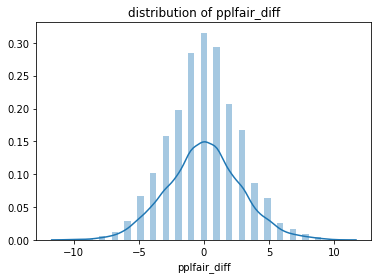

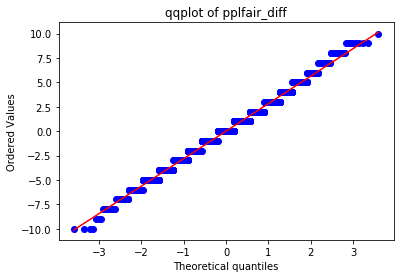

shapiro test for pplfair_diff
(0.9882275462150574, 2.2610835219578283e-18)


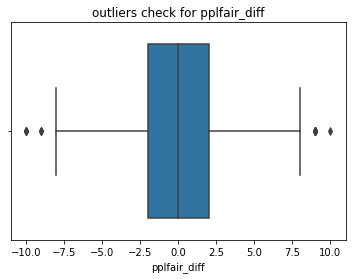

assumptions for parametric distribution comparison are not met - data not drawn from a normal distribution and there are outliers - so we'll use the Wilcoxon signed-rank test to compare distributions.

-------
Country CH
-------
2012 & 2014 means: 6.35064935064935 6.216883116883117
WilcoxonResult(statistic=103675.0, pvalue=0.24042108091361236)

-------
Country CZ
-------
2012 & 2014 means: 4.959938366718028 4.9029275808936825
WilcoxonResult(statistic=77678.0, pvalue=0.6060095202262115)

-------
Country DE
-------
2012 & 2014 means: 5.6923076923076925 6.6923076923076925
WilcoxonResult(statistic=9.0, pvalue=0.2059032107320684)

-------
Country ES
-------
2012 & 2014 means: 5.356725146198831 5.340852130325815
WilcoxonResult(statistic=262091.0, pvalue=0.6045094643061197)

-------
Country NO
-------
2012 & 2014 means: 6.927097661623109 6.862448418156808
WilcoxonResult(statistic=85352.5, pvalue=0.38601143880995137)

-------
Country SE
-------
2012 & 2014 means: 6.556541019955654 6.8325942350

/usr/local/lib/python3.7/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


In [11]:
#Did people become less trusting from 2012 to 2014? Compute results for each country in the sample.
#use a paired t-test
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

pplfair_df = create_paired_df(raw_df, "pplfair")

print("assumptions for parametric distribution comparison are not met - data not drawn from a normal distribution and there are outliers - so we'll use the Wilcoxon signed-rank test to compare distributions.")

pplfair_ts = wilcox(pplfair_df, "pplfair"+"_diff")



Only country SE had a statistically significant change in trust levels from 2012 to 2014 - and it was a very small change. 

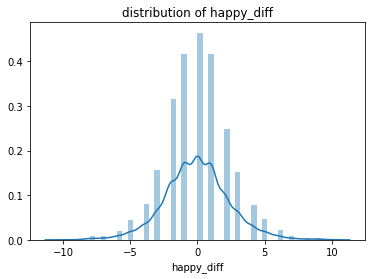

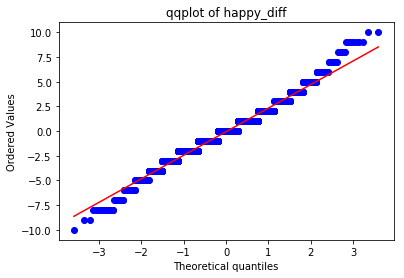

shapiro test for happy_diff
(0.9767217636108398, 7.35425008245296e-26)


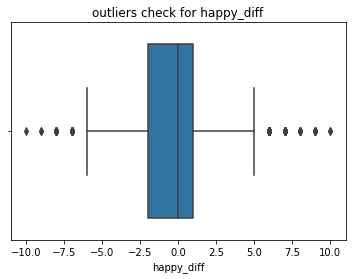

In [12]:
#Did people become happier from 2012 to 2014? Compute results for each country in the sample.

happy_df = create_paired_df(raw_df, "happy")

The dependent variable happy_diff is not normally distributed and has outliers, so we'll use a non-parametric distribution comparison test. 

In [13]:
happy_ts = wilcox(happy_df, "happy"+"_diff")


-------
Country CH
-------
2012 & 2014 means: 8.088311688311688 8.111688311688312
WilcoxonResult(statistic=92816.5, pvalue=0.989517215264762)

-------
Country CZ
-------
2012 & 2014 means: 6.7671875 6.9296875
WilcoxonResult(statistic=73213.0, pvalue=0.18319351815338547)

-------
Country DE
-------
2012 & 2014 means: 7.428571428571429 7.857142857142857
WilcoxonResult(statistic=23.5, pvalue=0.393351316918508)

-------
Country ES
-------
2012 & 2014 means: 7.54748142031379 7.420313790255987
WilcoxonResult(statistic=231958.5, pvalue=0.06262681782599841)

-------
Country NO
-------
2012 & 2014 means: 8.25171939477304 7.9119669876203575
WilcoxonResult(statistic=67571.5, pvalue=8.674043294010745e-06)

-------
Country SE
-------
2012 & 2014 means: 7.90929203539823 7.948008849557522
WilcoxonResult(statistic=125481.0, pvalue=0.6927836113719602)


Only country NO had a statistically significant change in happiness from 2012 to 2014.


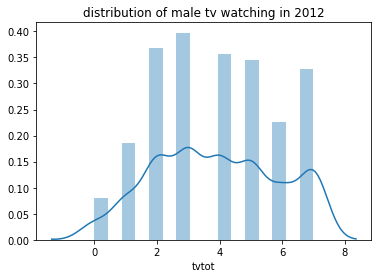

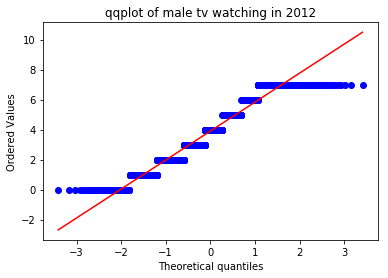

shapiro test for male tv watching in 2012
(0.9434293508529663, 5.994494507539187e-28)


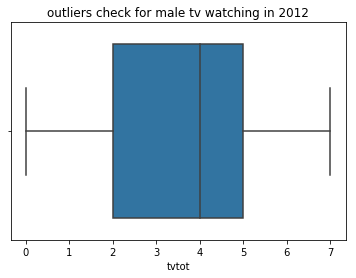

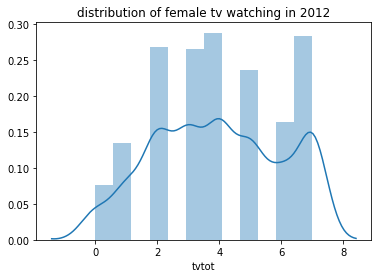

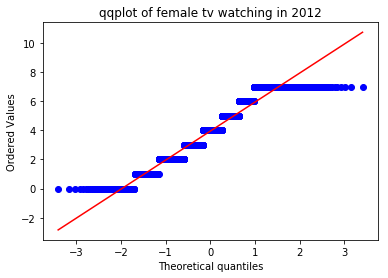

shapiro test for female tv watching in 2012
(0.9390434622764587, 8.488309331265169e-29)


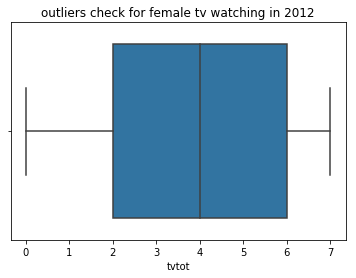

In [14]:
#Who reported watching more TV in 2012, men or women?

m_tv = raw_df.loc[(raw_df.year == 6) & (raw_df.gndr == 1), "tvtot"].dropna()
f_tv = raw_df.loc[(raw_df.year == 6) & (raw_df.gndr == 2), "tvtot"].dropna()

normality_check(m_tv, "male tv watching in 2012")
normality_check(f_tv, "female tv watching in 2012")


neither male nor female tv watching is normally distributed.  We'll use a non-parametric distribution compaison test. 


In [15]:
print("male and female 2012 tv watching medians are", m_tv.median(), f_tv.median())
stats.mannwhitneyu(m_tv, f_tv, alternative="two-sided")

male and female 2012 tv watching medians are 4.0 4.0


MannwhitneyuResult(statistic=2271081.5, pvalue=0.4476519699532031)

looks like tv watching was statistically the same across genders in 2012. 

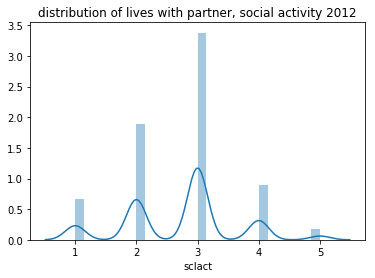

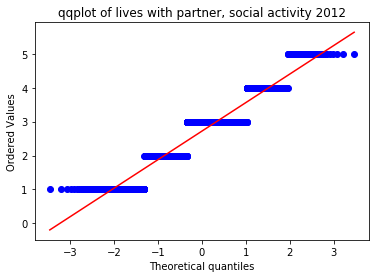

shapiro test for lives with partner, social activity 2012
(0.8827362060546875, 6.864821046880846e-41)


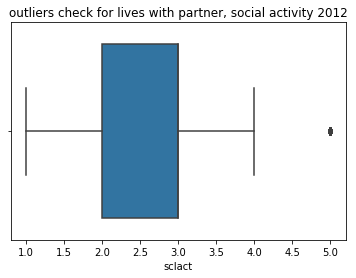

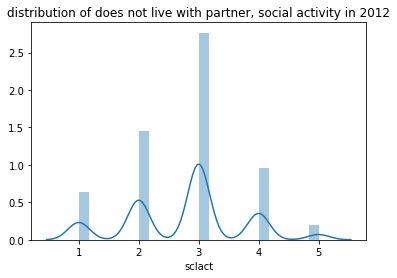

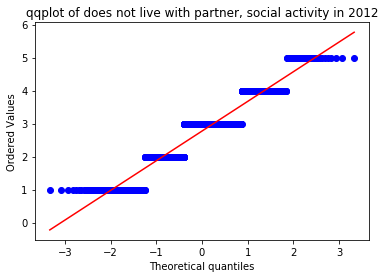

shapiro test for does not live with partner, social activity in 2012
(0.893856406211853, 8.692508597388601e-32)


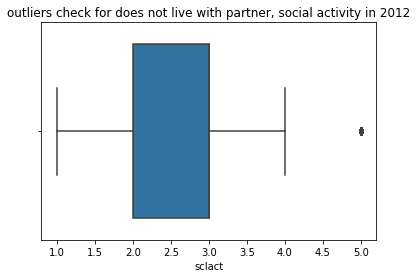

In [16]:
#Who was more likely to believe people were fair in 2012, people living with a partner or people living alone?

partner = raw_df.loc[(raw_df.year == 6) & (raw_df.partner == 1), "sclact"].dropna()
no_partner = raw_df.loc[(raw_df.year == 6) & (raw_df.partner == 2), "sclact"].dropna()

normality_check(partner, "lives with partner, social activity 2012")
normality_check(no_partner, "does not live with partner, social activity in 2012")



neither partner nor no-partner social activity is normally distributed.  We'll use a non-parametric distribution comparison test. 

In [17]:
print("partner and no-partner 2012 social activity medians are", partner.median(), "and", no_partner.median())
stats.mannwhitneyu(partner, no_partner, alternative="two-sided")


partner and no-partner 2012 social activity medians are 3.0 and 3.0


MannwhitneyuResult(statistic=2041280.5, pvalue=0.0491403004244873)

Interestingly, the medians are the same, but the populations are different.  Not sure how to interpret that...

Pick three or four of the countries in the sample and compare how often people met socially in 2014. Are there differences, and if so, which countries stand out?

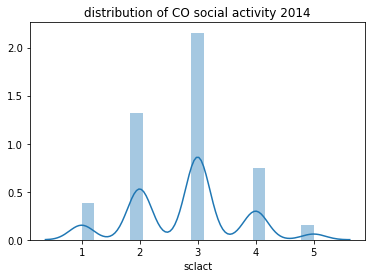

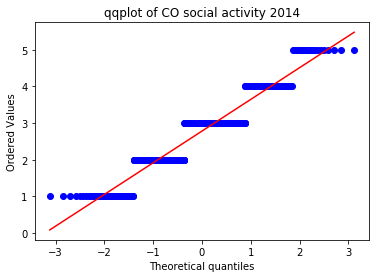

shapiro test for CO social activity 2014
(0.8931546211242676, 1.308755961383447e-22)


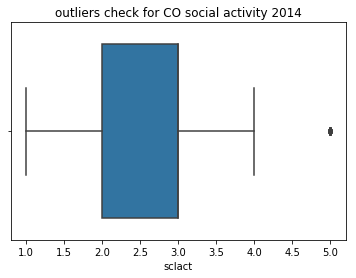

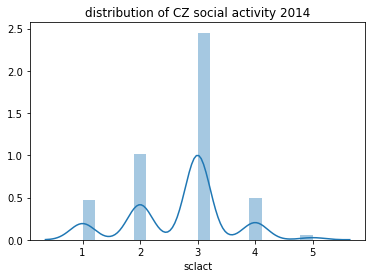

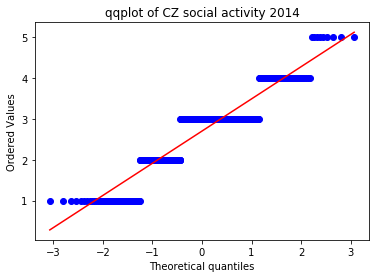

shapiro test for CZ social activity 2014
(0.8517600893974304, 3.2631608025549396e-24)


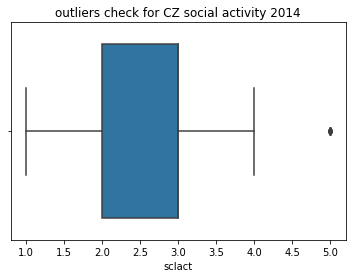

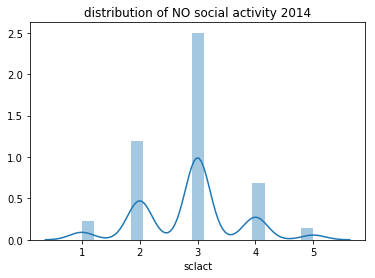

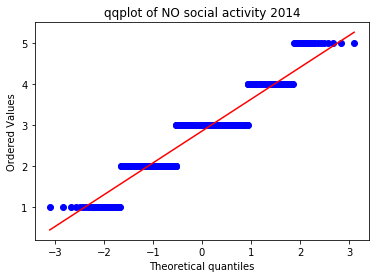

shapiro test for NO social activity 2014
(0.8678725957870483, 2.398206966061988e-24)


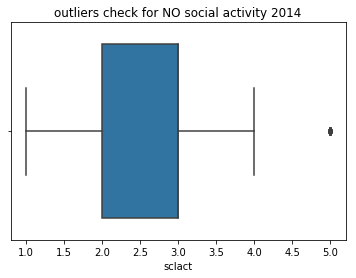

In [18]:
co_CH = raw_df.loc[(raw_df.year == 7) & (raw_df.cntry == "CH"), "sclact"].dropna()
co_CZ = raw_df.loc[(raw_df.year == 7) & (raw_df.cntry == "CZ"), "sclact"].dropna()
co_NO = raw_df.loc[(raw_df.year == 7) & (raw_df.cntry == "NO"), "sclact"].dropna()

normality_check(co_CH, "CO social activity 2014")
normality_check(co_CZ, "CZ social activity 2014")
normality_check(co_NO, "NO social activity 2014")



once again, none of the samples are normally distributed, so we'll use non-parametric distribution comparisoin methods. 

In [19]:
print("median social activity for the three countries are", 
      co_CH.median(), "and", co_CZ.median(), "and", co_NO.median())
print(stats.mood(co_CH, co_CZ))
print(stats.mood(co_CH, co_NO))
print(stats.mood(co_CZ, co_NO))



median social activity for the three countries are 3.0 and 3.0 and 3.0
(-3.9060321029149097, 9.38240525406081e-05)
(-3.2348995082912597, 0.0012168555072155232)
(-6.567523211351869, 5.115903948445074e-11)


Interestingly, the medians are the same, but the populations are statistically different.  Not sure how to interpret that...

Pick three or four of the countries in the sample and compare how often people took part in social activities, relative to others their age, in 2014. Are there differences, and if so, which countries stand out?

In [55]:
#define age rage bins
agebins = [15, 30, 50, 70, float("inf")]
agebin_labels = ["15-29", "30-49", "50-69", "70+"]
ages_df = raw_df[["cntry", "sclact", "agea"]].copy()
ages_df["age_bin"] = pd.cut(raw_df.agea, agebins, right=False, include_lowest=True,
                    labels=agebin_labels)
ages_df = ages_df.dropna()

for bin in agebin_labels:
    #get the sample for each country
    ch = ages_df.loc[(ages_df.cntry == "CH") & (ages_df["age_bin"] == bin), 
                    "sclact"]
    cz = ages_df.loc[(ages_df.cntry == "CZ") & (ages_df["age_bin"] == bin), 
                    "sclact"]
    no = ages_df.loc[(ages_df.cntry == "NO") & (ages_df["age_bin"] == bin), 
                    "sclact"]
    
    #run pairwise comparison tests across the samples
    print("median social activity for the three countries for age {} are".format(bin), 
      round(ch.mean(),2), "and", round(cz.mean(),2), "and", round(no.mean(),2))
    print("--------")
    print(stats.mood(ch, cz))
    print(stats.mood(ch, no))
    print(stats.mood(cz, no))
    print("--------")
    print("\n")


median social activity for the three countries for age 15-29 are 2.8 and 2.99 and 2.99
--------
(-2.934293825711212, 0.0033430757122128694)
(-2.8488470749647017, 0.004387796540666173)
(-6.3886724244072095, 1.6733207598859283e-10)
--------


median social activity for the three countries for age 30-49 are 2.75 and 2.6 and 2.86
--------
(-4.861597514455276, 1.1644219429131492e-06)
(-3.7923175679133947, 0.0001492478858687015)
(-5.477211818620492, 4.320798830211279e-08)
--------


median social activity for the three countries for age 50-69 are 2.72 and 2.62 and 2.89
--------
(-3.8669362383386465, 0.0001102112284922276)
(-0.7026061957975616, 0.4823012002420608)
(-1.5587803993968328, 0.11904836487893683)
--------


median social activity for the three countries for age 70+ are 2.71 and 2.45 and 2.96
--------
(-2.9437950622349383, 0.0032421460879785333)
(-0.852570813418461, 0.3938973537706133)
(-0.4195809109335949, 0.6747916358183615)
--------


